In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tonality-reviews/sample_submission.csv
/kaggle/input/tonality-reviews/train.csv
/kaggle/input/tonality-reviews/test.csv


In [2]:
!pip3 install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 235.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 6.8 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LsiModel, TfidfModel, Word2Vec, FastText, Doc2Vec

import re
import time
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from collections import Counter
import itertools
import pymorphy2

from tqdm import tqdm

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Загружаем данные, кратко посмотрим содержание датасетов

In [4]:
train = pd.read_pickle('/kaggle/input/tonality-reviews/train.csv')
train.head()

,Text,Score
0,"Итак, начнем с того, что решила я оформить кре...",Negative
1,Сначала было все банально. Взял в кредит mp3 п...,Negative
2,"Закрыл сегодня в Бинбанк-онлайн пару вкладов, ...",Negative
3,"Прошла неделя после объединения ББ столица, од...",Negative
4,11.01.2016 при посещение отделения банка по ад...,Negative


In [5]:
test = pd.read_pickle('/kaggle/input/tonality-reviews/test.csv').to_frame()
test.head()

,Text
0,"Добрый день, являюсь клиентом банка всего 3 ме..."
1,Удивлена ленью и некомпетентностью сотрудников...
2,"И все-таки самый худший банк, с которым мне ко..."
3,Здравствуйте!27 сентября 2014 года я вносил 33...
4,Уже больше года являюсь клиентом банка. В цело...


### Была идея рассмотреть две библиотеки: pymorphy2 и natasha, но под капотом natasha использует тот же pymorphy

In [6]:
morph = pymorphy2.MorphAnalyzer()
# Стоп-слова и пунктуация нам не нужны
stop_words = set(stopwords.words('russian'))
punkt = list(string.punctuation)

In [7]:
# Взял из ноутбука предобработку, добавил отсев односимвольных слов, так как они точно не несут никакого смысла
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r' ',text)

# убрать HTML разметку
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r' ',text)

def remove_mail(text):
    mail=re.compile(r'^([a-z0-9_\.-]+)@([a-z0-9_\.-]+)\.([a-z\.]{2,6})$')
    return mail.sub(r' ',text)

# убрать эмодзи
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

# напишем нашу функцию токенизации, с учетом всего рассмотренного
stop_words = set(stopwords.words("russian"))
def mytokenize(text):
    text = remove_html(text)
    text = remove_URL(text)
    text = remove_emoji(text)
    text = remove_mail(text)
    text = text.lower()
    text = re.sub("[^а-яёйa-z0-9]", " ", text)
    text = re.sub("\s+", " ", text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalpha()]
    text = [word for word in text if not word in stop_words]
    text = [word for word in text if len(word)>1]
#     text = [morph.normal_forms(word)[0] for word in text]
    return text

In [8]:
# Токенизация
train['tokens'] = train.Text.apply(mytokenize)
test['tokens'] = test.Text.apply(mytokenize)

# Лемматизация (pymorphy) + соединение слов в отзыве в строку
train['prep_text'] = ''
test['prep_text'] = ''
for i in range(len(train)):
    train.tokens[i] = [morph.parse(word)[0].normal_form for word in train.tokens[i]]
    train['prep_text'][i] = ' '.join(train['tokens'][i])
for i in range(len(test)):
    test.tokens[i] = [morph.parse(word)[0].normal_form for word in test.tokens[i]]
    test['prep_text'][i] = ' '.join(test['tokens'][i])

# Перевод в числовой вид решающей переменной
train['Score'].replace('Positive', 1, inplace=True)
train['Score'].replace('Negative', 0, inplace=True)

# Результат
train.head()

,Text,Score,tokens,prep_text
0,"Итак, начнем с того, что решила я оформить кре...",0,"[итак, начать, решить, оформить, кредитный, ка...",итак начать решить оформить кредитный карта мо...
1,Сначала было все банально. Взял в кредит mp3 п...,0,"[сначала, банально, взять, кредит, плеер, мес,...",сначала банально взять кредит плеер мес платит...
2,"Закрыл сегодня в Бинбанк-онлайн пару вкладов, ...",0,"[закрыть, сегодня, бинбанк, онлайн, пара, вкла...",закрыть сегодня бинбанк онлайн пара вклад день...
3,"Прошла неделя после объединения ББ столица, од...",0,"[пройти, неделя, объединение, бб, столица, одн...",пройти неделя объединение бб столица однако би...
4,11.01.2016 при посещение отделения банка по ад...,0,"[посещение, отделение, банк, адрес, спб, наб, ...",посещение отделение банк адрес спб наб обводны...


### Есть идея оценивать эмодзи по тональности, но я не нашёл библиотеки с разделением на положительные/негативные эмодзи, вручную делать это крайне долго (можно обучить модель для этого, но тут задание не предполагает этого)

# TF-IDF (реализован в виде функции TfidfVectorizer())
### Bag-of-words (реализован в виде функции CountVectorizer()) (реализован в версии 6).

## Отдельно составлю список слов (из положительных/отрицательных/всех отзывов с количеством их употребления.

1    8018
0    7981
Name: Score, dtype: int64


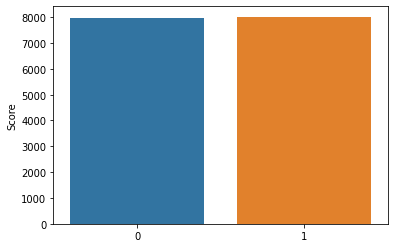

In [9]:
# Распределение практически 50/50, это хорошо
score = train['Score'].value_counts()
sns.barplot(x=score.index,y=score)
print(score)

In [10]:
# Составляем общий список слов для анализа полученных данных
# Вычисление уникальных слов для посчёта их количества
vocab = []
raw_vocab = list(itertools.chain(*train.tokens.values, *test.tokens.values))
print('Всего', len(raw_vocab), "слов")
vocab = pd.Series(raw_vocab).value_counts()
print('Всего уникальных', len(vocab), "слов")
vocab[:50]

Всего 3017424 слов
Всего уникальных 44155 слов


банк            96978
карта           45170
это             26734
день            23415
мой             22753
кредит          21493
сотрудник       21154
который         20787
счёт            20199
деньга          19950
отделение       19511
клиент          19494
год             15149
вопрос          14377
сказать         14312
очень           13683
свой            13678
время           13150
сумма           12998
кредитный       12707
офис            11354
альфа           11297
получить        11082
мочь            10963
такой           10936
проблема        10035
заявление        9669
работа           9285
договор          9048
платёж           8973
телефон          8972
банкомат         8892
позвонить        8867
документ         8748
месяц            8720
ответ            8576
обслуживание     8446
дать             8419
хотеть           8391
решить           8370
услуга           8224
звонить          8213
какой            8079
претензия        8073
работать         8037
ваш       

False    34551
True      9604
dtype: int64


<AxesSubplot:>

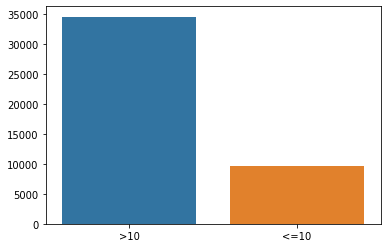

In [11]:
# Крайне много слов, которые употребляются очень редко (менее 10 упоминаний на весь корпус текста)
print(vocab.groupby(vocab>10).count())
sns.barplot(x=['>10', '<=10'],y=vocab.groupby(vocab>10).count())

In [12]:
# Зафиксируем список слов, количество которых в общем списке меньше 10
set_less10 = frozenset(vocab[vocab<10].index)

In [13]:
# Попробуем убрать редкие слова
vocab_more10 = []
vocab_more10 = list(itertools.chain(*train.tokens.values, *test.tokens.values))
vocab_more10 = [item for item in vocab_more10 if item not in set_less10]
print('Всего', len(vocab_more10), "слов")
vocab_more10 = pd.Series(vocab_more10).value_counts()
print('Всего уникальных', len(vocab_more10), "слов")
# Количество изменилось всего на почти 30000 слов (~2-3%), а количество уникальных снизилось на 70%

Всего 2941569 слов
Всего уникальных 10092 слов


In [14]:
# Выведем топ 15 слов из негативных отзывов
neg_vocab = []
neg_vocab = list(itertools.chain(*train[train['Score']==0].tokens.values))
print('Всего', len(neg_vocab), "слов")
neg_vocab = pd.Series(neg_vocab).value_counts()
print('Всего уникальных', len(neg_vocab), "слов")
print(neg_vocab[:30])

# Попробуем убрать редкие слова
neg_vocab = []
neg_vocab = list(itertools.chain(*train[train['Score']==0].tokens.values))
neg_vocab_more10 = [item for item in neg_vocab if item not in set_less10]
print('Всего', len(neg_vocab_more10), "слов")
neg_vocab_more10 = pd.Series(neg_vocab_more10).value_counts()
print('Всего уникальных', len(neg_vocab_more10), "слов")
# Количество изменилось всего на почти 30000 слов (~2-3%), а количество уникальных снизилось на 60%

Всего 1317105 слов
Всего уникальных 26541 слов
банк         43168
карта        20981
это          11985
мой          11165
день         11101
счёт         10352
сотрудник     9934
деньга        9668
который       9634
кредит        9110
клиент        8317
отделение     8100
сказать       7454
альфа         7297
сумма         6844
год           6096
кредитный     5977
свой          5814
вопрос        5758
претензия     5496
мочь          5461
время         5386
заявление     5358
договор       5127
звонить       5109
получить      5088
ответ         5060
телефон       4992
такой         4819
номер         4778
dtype: int64
Всего 1289104 слов
Всего уникальных 9869 слов


In [15]:
# Аналогично выведем топ 15 слов из позитивных отзывов
pos_vocab = []
pos_vocab = list(itertools.chain(*train[train['Score']==1].tokens.values))
print('Всего', len(pos_vocab), "слов")
pos_vocab = pd.Series(pos_vocab).value_counts()
print('Всего уникальных', len(pos_vocab), "слов")
print(pos_vocab[:30])

# Попробуем убрать редкие слова
pos_vocab = []
pos_vocab = list(itertools.chain(*train[train['Score']==1].tokens.values))
pos_vocab_more10 = [item for item in pos_vocab if item not in set_less10]
print('Всего', len(pos_vocab_more10), "слов")
pos_vocab_more10 = pd.Series(pos_vocab_more10).value_counts()
print('Всего уникальных', len(pos_vocab_more10), "слов")
# Количество изменилось всего на почти 30000 слов (~2-3%), а количество уникальных снизилось на 60%

Всего 1084541 слов
Всего уникальных 29322 слов
банк            34358
карта           15062
это              9225
очень            8322
кредит           8129
день             7573
отделение        7442
клиент           7316
мой              7075
сотрудник        7058
который          6889
деньга           6197
год              5939
вопрос           5712
счёт             5625
время            5068
свой             5021
офис             4895
работа           4662
проблема         4406
кредитный        4220
спасибо          4172
обслуживание     3973
сказать          3938
хотеть           3867
такой            3831
вклад            3805
получить         3598
сумма            3497
документ         3327
dtype: int64
Всего 1052398 слов
Всего уникальных 9944 слов


## Основные слова у позитивных и негативных отзывов примерно одинаковы, значит они несут не так много смысла. Также в корпусе текстов очень много редких слов, которые редко несут в себе ключевой смысл, значит их можно убрать.

## TfIdfVectorizer
### также опробовать с ним алгоритмы: knn, logreg

In [16]:
# TfidfVectorizer (с биграммами)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.2, min_df=10)
vectorizer.fit(train['prep_text'].append(test['prep_text']))
X = vectorizer.transform(train['prep_text'])
X_test = vectorizer.transform(test['prep_text'])
y = train['Score']

In [17]:
# Проверяем размерности
X

<15999x45999 sparse matrix of type '<class 'numpy.float64'>'
	with 2271495 stored elements in Compressed Sparse Row format>

In [18]:
X_test

<4000x45999 sparse matrix of type '<class 'numpy.float64'>'
	with 578561 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.decomposition import TruncatedSVD

# Попробуем обобщить модель, объединив слова в категории с помощью латентно-семантического анализа
lsa_model = TruncatedSVD(n_components=1000, n_iter=10, random_state=42)
lsa=lsa_model.fit_transform(np.concatenate((X.toarray(), X_test.toarray()), axis=0))

X_test = lsa[-4000:]
lsa = lsa[:-4000]

# Проверка размерностей
print(lsa.shape, X_test.shape)
lsa[:5]

(15999, 1000) (4000, 1000)


array([[ 0.17920203, -0.07374076,  0.02296663, ..., -0.00351308,
        -0.00950609,  0.01736267],
       [ 0.17943003, -0.08683475, -0.02720853, ..., -0.00208947,
         0.01527541,  0.01037595],
       [ 0.10981697, -0.01283114,  0.06431044, ...,  0.0159171 ,
         0.01319301,  0.00936961],
       [ 0.15561744,  0.02220759,  0.03550838, ...,  0.02283557,
        -0.00478875,  0.00320794],
       [ 0.16390351, -0.08137228, -0.03079205, ...,  0.00671066,
        -0.00465314,  0.00352631]])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(lsa, y, test_size=0.2, random_state=42)
# Взял функцию из otzivi, она там хорошо и лаконично показывает результат, добавил отображение времени в секундах
result = pd.DataFrame(columns=['vecModel', 'model', 'accuracy_score', 'f1_score', 'time'])
def run_model(vecModel, model, X_train, X_val, y_train, y_val, result):
    start_time = time.clock()
    y_val_pred = model.fit(X_train, y_train).predict(X_val)
    result_time = time.clock() - start_time
    result.loc[result.shape[0]] = [vecModel, str(model), accuracy_score(y_val, y_val_pred), f1_score(y_val, y_val_pred), result_time]
    return vecModel, model
print(X_train.shape, X_val.shape)

(12799, 1000) (3200, 1000)


In [21]:
# Наивный Байес не подходит к работе с LDA/LSI, потому что с понижением размерности переменные становятся зависимыми,
# а Наивный Байес работает только с независимыми переменными
run_model('tf-idf_10to0,2_bigram_lsa1000', GradientBoostingClassifier(), X_train, X_val, y_train, y_val, result)
run_model('tf-idf_10to0,2_bigram_lsa1000', LogisticRegression(), X_train, X_val, y_train, y_val, result)
run_model('tf-idf_10to0,2_bigram_lsa1000', KNeighborsClassifier(), X_train, X_val, y_train, y_val, result)
run_model('tf-idf_10to0,2_bigram_lsa1000', SVC(C=3, gamma=0.2), X_train, X_val, y_train, y_val, result)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock

('tf-idf_10to0,2_bigram_lsa1000', SVC(C=3, gamma=0.2))

In [22]:
result

,vecModel,model,accuracy_score,f1_score,time
0,"tf-idf_10to0,2_bigram_lsa1000",GradientBoostingClassifier(),0.917813,0.916904,465.382047
1,"tf-idf_10to0,2_bigram_lsa1000",LogisticRegression(),0.953750,0.953459,1.907316
2,"tf-idf_10to0,2_bigram_lsa1000",KNeighborsClassifier(),0.784375,0.801724,6.510486
3,"tf-idf_10to0,2_bigram_lsa1000","SVC(C=3, gamma=0.2)",0.958438,0.958110,58.734586


# Bag-Of_words:
### Многие алгоритмы на нём будут работать так себе, но для нас это базовое решение, от которого мы будем смотреть динамику результатов.

model accuracy_score f1_score time

GaussianNB() 0.658125 0.594815 11.616017

SVC(C=3, gamma=0.2) 0.507500 0.074031 583.801286

GradientBoostingClassifier() 0.914375 0.913016 51.207989

# TF-IDF
### Все алгоритмы показали улучшение результата из-за снижения размера переменных, особенно SVM

model accuracy_score f1_score time

GaussianNB() 0.669375 0.634921 10.025226

GradientBoostingClassifier() 0.912188 0.910935 81.996412

LogisticRegression() 0.952812 0.952768 5.771546

KNeighborsClassifier() 0.815000 0.787966 3.658578

SVC(C=3, gamma=0.2) 0.956875 0.956821 80.215084

# TF-IDF без редких слов

### Скорость работы выросла у всех, кроме KNN

### Наивный Байес показал большую прибавку к точности, остальные работают примерно так же

model accuracy_score f1_score time

GaussianNB()	0.807500	0.808219	2.358762

GradientBoostingClassifier()	0.912188	0.910935	43.745193

LogisticRegression()	0.953125	0.953066	3.721916

KNeighborsClassifier()	0.824688	0.801837	3.795682

SVC(C=3, gamma=0.2)	0.957500	0.957367	71.331705

# TF-IDF без редких и частых слов

### Все алгоритмы стали работать чуть хуже.

### Логистическая регрессия стала работать крайне быстро, хороший вариант для интерактивной работы

### По совету я стал использовать мультиномиального Наивного Байеса, он показал заметное улучшение результата относительно гауссова Наивного Байеса

model	accuracy_score	f1_score	time

MultinomialNB()	0.926250	0.925505	1.036015

GradientBoostingClassifier()	0.896875	0.894163	34.258743

LogisticRegression()	0.952812	0.952590	0.250303

KNeighborsClassifier()	0.815937	0.794702	2.969132

SVC(C=3, gamma=0.2)	0.952812	0.952471	65.909516

# TF-IDF без редких и частых слов с биграммами

### Все алгоритмы стали работать немного лучше, относительно других вариантов предобработки, кроме решения с деревьями (градиентный бустинг)

### Все алгоритмы стали работать заметно дольше

vecModel	model	accuracy_score	f1_score	time

MultinomialNB()	0.931250	0.930861	4.595049

GradientBoostingClassifier()	0.902813	0.900225	61.432362

LogisticRegression()	0.953438	0.953218	5.404199

KNeighborsClassifier()	0.827187	0.810681	4.028652

SVC(C=3, gamma=0.2)	0.959375	0.959119	170.842733

# LSA (Латентно-семантический анализ) и LDA (Латентное размещение Дирихле)

# TF-IDF без редких и частых слов, с LSI (1000 категорий)

### Результаты ухудшились.

### Нормализация портит результат

model	accuracy_score	f1_score	time

GradientBoostingClassifier()	0.911563	0.910244	490.110150

LogisticRegression()	0.950937	0.950706	2.274439

KNeighborsClassifier()	0.712500	0.759916	6.646384

SVC(C=3, gamma=0.2)	0.952500	0.952231	67.665378

# TF-IDF без редких и частых слов с биграммами, с LSI (1000)

### Долго, но результат получается неплохой

### Дальнейшее уменьшение размерности портит результат на всех алгоритмах, кроме градбустинга (из-за обобщающих свойств)

model	accuracy_score	f1_score	time

GradientBoostingClassifier()	0.919687	0.918902	492.319498

LogisticRegression()	0.953438	0.953159	1.947848

KNeighborsClassifier()	0.794375	0.812322	6.562554

SVC(C=3, gamma=0.2)	0.958438	0.958216	71.395366

# TF-IDF без редких и частых слов, с LDA

# TF-IDF без редких и частых слов с биграммами, с LDA

# Сохранение и загрузка результата

In [23]:
# Формат загружаемого предсказывания
sample = pd.read_csv('/kaggle/input/tonality-reviews/sample_submission.csv')
sample.head()

,id,Score
0,0,Positive
1,1,Positive
2,2,Positive
3,3,Positive
4,4,Positive


In [24]:
model = SVC(C=3, gamma=0.2)
y_pred = model.fit(lsa, y).predict(X_test)
submission = pd.DataFrame(y_pred, columns=['Score'])
submission = submission.reset_index().rename(columns={"index": "id"})
# Перевод в изначальный вид решающей переменной
submission['Score'].replace(1, 'Positive', inplace=True)
submission['Score'].replace(0, 'Negative', inplace=True)
submission

,id,Score
0,0,Positive
1,1,Negative
2,2,Negative
3,3,Negative
4,4,Positive
...,...,...
3995,3995,Negative
3996,3996,Negative
3997,3997,Negative
3998,3998,Negative


In [25]:
submission.to_csv('submit.csv',index=False)